# QT Course: single-electron regime

This notebook contains exercises for the QT course on spin-qubits.

We show how to measure CSDs and provide an interactive widget. The model resembles the spin-qubit dot setup. The hardware consists of a virtual keithley, IVVI racks and a virtual gates object.

<pieter.eendebak@tno.nl>

Online: https://mybinder.org/v2/gh/QuTech-Delft/quantum-inspire-examples/qa?filepath=docs/notebooks

In [2]:
# Load packages and configure simulator
from pathlib import Path
import sys

cwd = Path().resolve()
sys.path.append(cwd)

import standalone_virtual_system
from standalone_virtual_system import create_virtual_system, ScanRange, plot_dataset, MultiDot

#%%
from functools import partial
import numpy as np
from qcodes import find_or_create_instrument
from quantify_core.measurement import MeasurementControl
from qtt.utilities.tools import measure_time
import ipywidgets as widgets
from rich import print as rprint
from ipywidgets import interact, widgets
from quantify_core.data.handling import to_gridded_dataset
import matplotlib.pyplot as plt


MC = find_or_create_instrument(MeasurementControl, "MC")
MC.verbose(False)

import matplotlib.pyplot as plt

def make_sliders(slider_gates:list[str], scan_range=400):
    sliders = {key: widgets.FloatSlider(value=gates.get(key), min=-800, max=500, description=f'{key} [mV]', continuous_update=False) for ii,key in enumerate(slider_gates)  }
    sliders['nx']=widgets.IntSlider(value=60, min=10, max=160, description='nx', continuous_update=False)
    sliders['ny']=widgets.IntSlider(value=60, min=10, max=100, description='ny', continuous_update=False)
    
    sliders['range_x']=widgets.IntSlider(value=scan_range, min=.1, max=800, description='Range x [mV]', continuous_update=False)
    sliders['range_y']=widgets.IntSlider(value=scan_range, min=.1, max=800, description='Range y [mV]', continuous_update=False)

    sliders['gate_x']  =   widgets.Dropdown(
        options=slider_gates,
        value=slider_gates[0],
        description='Gate 1:',
        disabled=False,
        )
    sliders['gate_y']  =   widgets.Dropdown(
        options=slider_gates,
        value=slider_gates[1],
        description='Gate 2:',
        disabled=False,
        )
    return sliders



def make_csd(*args, station=None,  verbose=0, **kwargs):
    model=station.model
    gates = station.gates
    keithley1, keithley3 = station.components[f'{model.name}_keithley1'], station.components[f'{model.name}_keithley3']

    if verbose:
        print('interactive method: ', args, kwargs)

    nx,ny=kwargs.get('nx',50), kwargs.get('ny', 50)
    scanrange=kwargs.get('range_x',500), kwargs.get('range_y', 500)
    gate_x, gate_y=kwargs.get('gate_x'), kwargs.get('gate_y')
    with measure_time(message='calculation time:'):
      with gates.restore_at_exit():
        for g, v in kwargs.items():      
            if g in gates.parameters:
              gates.set(g, v)
              if verbose>=2:
                  print(f'set {g} to {v}')
        s = ScanRange.around_current(
            [getattr(gates, gate_x), getattr(gates, gate_y)],
            scanrange=scanrange,
            number_of_points=[nx, ny],
        )
        s.apply(MC)
    
        MC.gettables(keithley1.amplitude)
        dataset = MC.run("2D charge stability diagram", save_data=False)
        g=to_gridded_dataset(dataset)

    ax=plt.gca()
    if verbose>=2:
        print('update plot')
    g.y0.transpose().plot(ax=ax, add_colorbar=False)
    s.draw_crosshair(alpha=.2)

## Exercise 1

We model a classical double quantum dot. Making a charge stability diagram (CSD) shows an anti-crossing.

In [3]:
# System for exercise 1
station = create_virtual_system(nr_dots=2, maxelectrons=3, name='double_dot')
model=station.model
ds=model.ds
gates=station.gates
keithley1, keithley3 = station.components[f'{model.name}_keithley1'], station.components[f'{model.name}_keithley3']
gates.P1(-320); gates.P2(-265)
ds.data.tunneling=[1.1]
ds.data.inter_site_charging=[12.1]
#rprint(ds.data)

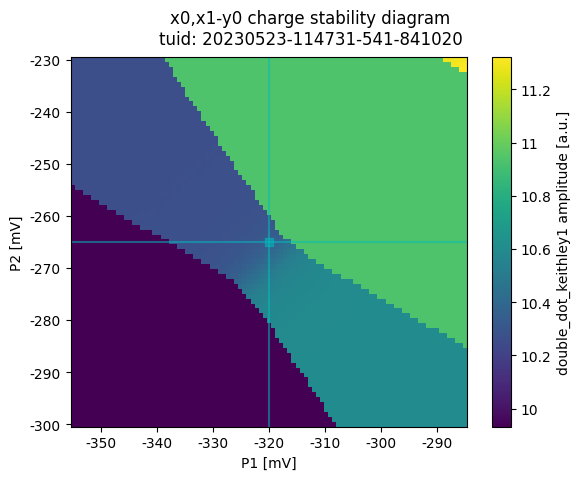

In [4]:
with gates.restore_at_exit():
    s = ScanRange.around_current(
        [gates.P1, gates.P2],
        scanrange=[70, 70],
        number_of_points=[97, 75]
    )
    s.apply(MC)

    MC.gettables(keithley1.amplitude)
    dataset = MC.run("charge stability diagram", save_data=False)

plot_dataset(dataset, fig=1)
s.draw_crosshair()

The widget below models a double quantum dot. Play around with the settings to see the impact on the CSD. What is the role of the tunnel coupling.

In [6]:
sliders= make_sliders(slider_gates=['P1', 'P2', 'B1', 'B0'], scan_range=70)
layout=layout = widgets.Layout(grid_template_columns='1fr 1fr 1fr')
ui = widgets.GridBox(list(sliders.values()), layout=layout)

out = widgets.interactive_output(partial(make_csd, station=station), sliders)
display(ui, out)

GridBox(children=(FloatSlider(value=-320.0, continuous_update=False, description='P1 [mV]', max=500.0, min=-80…

Output()

## Exercise 2

The widget below models a 4-dot system. Try to tune the system to the (1,3,3,1)-configuration.

In [7]:
# System for exercise 2
station = create_virtual_system(nr_dots=4, maxelectrons=3)
model=station.model
model.sdnoise=.07
gates = station.gates
keithley1, keithley3 = station.components[f'{model.name}_keithley1'], station.components[f'{model.name}_keithley3']

M = np.array([[1, -0.1, -0.01], [0.1, 1, -0.1], [-0.03, -0.11, 1]])
gates.add_virtual_gate_matrix("test2", ["P1", "B1", "P2"], matrix=M)
gates.hardware.awg2dac_ratios = {gate: 80 / 1000 for gate in ["P1", "P2", "B1", "B2", "P3"]}

for ii in range(1, 17):
    getattr(station.components[f'{model.name}_ivvi1'], f'dac{ii}').vals = None
    getattr(station.components[f'{model.name}_ivvi2'], f'dac{ii}').vals = None

gates.P1(-220)
gates.P2(-210)

NameError: name 'MultiDot' is not defined

In [ ]:
with gates.restore_at_exit():
        s = ScanRange.around_current(
            [gates.P1, gates.P2],
            scanrange=[700, 700],
            number_of_points=[37, 35],
        )
        s.apply(MC)
    
        MC.gettables(keithley1.amplitude)
        dataset = MC.run("2D charge stability diagram", save_data=False)
        g=to_gridded_dataset(dataset)
plot_dataset(dataset, fig=1)

In [40]:
sliders= make_sliders(slider_gates=['P1', 'P2', 'P3', 'P4'], scan_range=60)
layout=layout = widgets.Layout(grid_template_columns='1fr 1fr 1fr')
ui = widgets.GridBox(list(sliders.values()), layout=layout)

out = widgets.interactive_output(partial(make_csd, station=station) , sliders)
display(ui, out)

GridBox(children=(FloatSlider(value=-220.0, continuous_update=False, description='P1 [mV]', max=500.0, min=-80…

Output()

End of the exercises.